# Ejercicio 13 examen
## Emiliano Valderrama del Toro

 ## Simulación de inversión periódica (Dollar Cost Averaging)

C:\Users\Admin\AppData\Local\Temp\ipykernel_4700\14715093.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed



Estrategia: Inversión Única
Valor final promedio: $6,074.79
Desviación estándar: $1,295.99
Probabilidad de pérdida: 21.08%

Estrategia: DCA (Inversión Periódica)
Valor final promedio: $5,533.84
Desviación estándar: $705.91
Probabilidad de pérdida: 23.15%


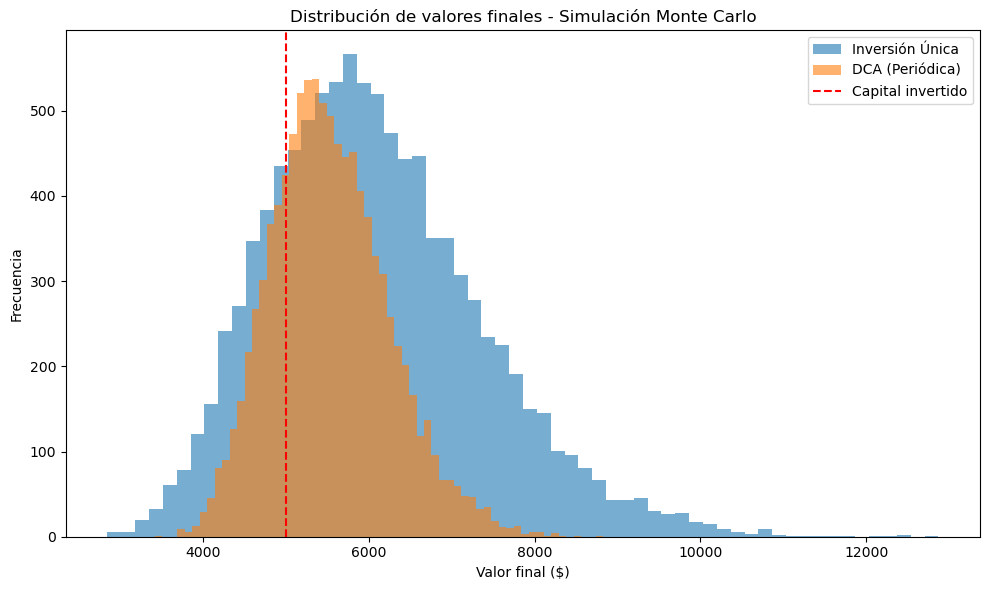

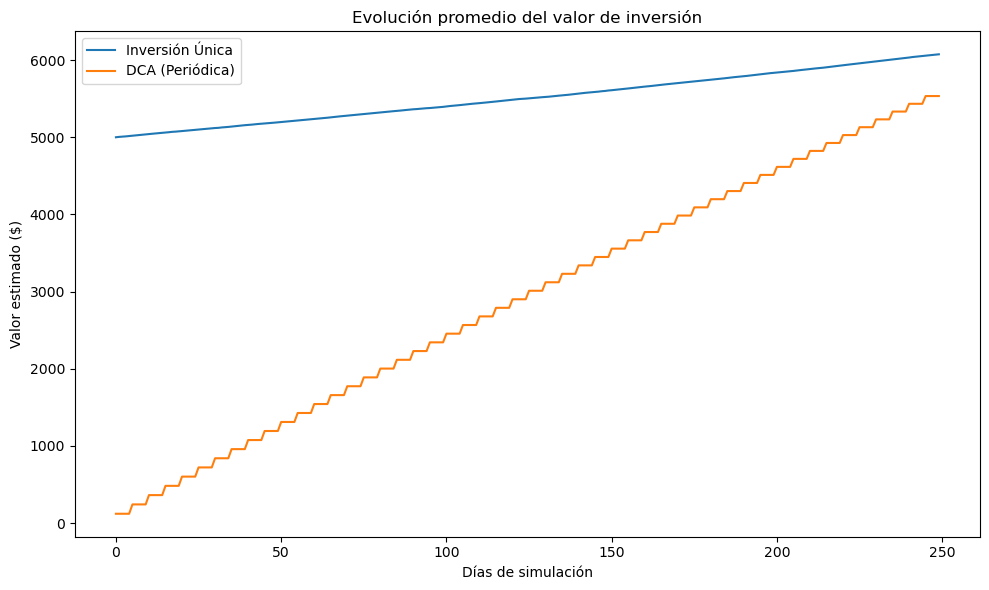

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# Parámetros
TICKER = 'COST'
CAPITAL_TOTAL = 5000
APORTE = 100 
N_SIMULATIONS = 10000
DAYS_PER_YEAR = 252
WEEK_DAYS = 5
SEED = 42

np.random.seed(SEED)

# Fechas
end_date = datetime.today()
start_date = end_date - timedelta(days=365*3 + 30)

# Descargar precios
data = yf.download(TICKER, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

if isinstance(data, pd.Series):
    data = data.to_frame()

prices = data['Close']

# Rendimientos diarios y log-retornos
returns = prices.pct_change().dropna()
log_returns = np.log(1 + returns)
mu_log = float(log_returns.mean())
sigma_log = float(log_returns.std())

# Número de semanas y días totales de simulación
WEEKS = CAPITAL_TOTAL // APORTE
T = WEEKS * WEEK_DAYS
S0 = float(prices.iloc[-1])  # convertir a escalar

# Simulación Monte Carlo de trayectorias
Z = np.random.standard_normal((T, N_SIMULATIONS))
price_paths = np.zeros((T, N_SIMULATIONS))
price_paths[0, :] = S0

for t in range(1, T):
    price_paths[t, :] = price_paths[t-1, :] * np.exp((mu_log - 0.5 * sigma_log**2) + sigma_log * Z[t, :])

# Estrategia 1: Inversión única
final_values_lump = price_paths[-1, :] / price_paths[0, 0] * CAPITAL_TOTAL

# Estrategia 2: DCA
weekly_indices = np.arange(0, T, WEEK_DAYS)
values_dca = np.zeros(N_SIMULATIONS)
for i in range(N_SIMULATIONS):
    prices_sim = price_paths[:, i]
    units = 0
    for idx in weekly_indices[:WEEKS]:
        units += APORTE / prices_sim[idx]
    values_dca[i] = units * prices_sim[-1]

# Estadísticas
def resumen(valores, nombre):
    media = np.mean(valores)
    std = np.std(valores)
    prob_perdida = np.mean(valores < CAPITAL_TOTAL)
    print(f"\nEstrategia: {nombre}")
    print(f"Valor final promedio: ${media:,.2f}")
    print(f"Desviación estándar: ${std:,.2f}")
    print(f"Probabilidad de pérdida: {prob_perdida*100:.2f}%")
    return media, std, prob_perdida

media_lump, std_lump, prob_lump = resumen(final_values_lump, "Inversión Única")
media_dca, std_dca, prob_dca = resumen(values_dca, "DCA (Inversión Periódica)")

# Histogramas
plt.figure(figsize=(10, 6))
plt.hist(final_values_lump, bins=60, alpha=0.6, label='Inversión Única')
plt.hist(values_dca, bins=60, alpha=0.6, label='DCA (Periódica)')
plt.axvline(CAPITAL_TOTAL, color='red', linestyle='--', label='Capital invertido')
plt.title('Distribución de valores finales - Simulación Monte Carlo')
plt.xlabel('Valor final ($)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.savefig('histograma_inversiones.png', dpi=300)
plt.show()

# Evolución promedio
promedio_lump = np.mean(price_paths / price_paths[0, 0] * CAPITAL_TOTAL, axis=1)
promedio_dca = np.zeros(T)
for idx in weekly_indices[:WEEKS]:
    promedio_dca[idx:] += APORTE * np.mean(price_paths[-1, :] / price_paths[idx, :])

plt.figure(figsize=(10, 6))
plt.plot(promedio_lump, label='Inversión Única')
plt.plot(promedio_dca, label='DCA (Periódica)')
plt.title('Evolución promedio del valor de inversión')
plt.xlabel('Días de simulación')
plt.ylabel('Valor estimado ($)')
plt.legend()
plt.tight_layout()
plt.savefig('evolucion_promedio_inversion.png', dpi=300)
plt.show()